# Setup
## Constants

In [1]:
!pip install transformers -q
!pip install torch -q
!pip install torchvision -q

In [2]:
# False if you have already created and saved a .pth file to PTH_SAVE_PATH
CREATE_NEW_DATASET = True

# train, test, val set size. Should sum to 1
SET_SIZES = {
    "train": 0.8,
    "test": 0.1,
    "val": 0.1,
}

# samples per class in uniform dataset
N_SAMPLES = 400

# path to dataset (do not change)
HM_DATA_PATH = "../dataset/"

# path to pth saves (do not change)
PTH_SAVE_PATH = "../pth/"

## Imports

In [3]:
import os, sys, random, importlib, transformers, itertools, copy
import numpy as np, torch.nn as nn, torch, seaborn as sns, matplotlib.pyplot as plt, pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
print(os.getcwd())# Our own files
# sys.path.append('./src/')
import model_functions, utils, training, datasets
def set_seed(seed):# reproducable
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(0)

/home/jupyter/DD2430_Project/src


In [4]:
def update():# if you change our files
    import model_functions, utils, training, datasets
    for lib in [model_functions, utils, training, datasets]:
        importlib.reload(lib)# issues with not updating
update()

In [5]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available(): # For apple silicon
    device = 'mps'
print("Using device:", device)

Using device: cuda


In [6]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


# Dataset

### Full dataset, run once

In [37]:
df = pd.read_csv(HM_DATA_PATH+'articles_filtered.csv')
embs = torch.load(HM_DATA_PATH+'embedds.pth', weights_only=True) # all 100k embeddings
labs = torch.load(HM_DATA_PATH+'labels.pth', weights_only=True).tolist() #  100k labels
hmd = datasets.HMDatasetDuplicates(embs, np.array(labs), df)
print(hmd.article_id2suclass(694805002, 'garment_group_name'))
#print(hmd.list_article_id2suclass(labs, 'garment_group_name'))#all
print(len(labs))
BALANCED = False

Knitwear
105099


In [38]:
# Get unique column names and their counts
unique_columns = df.nunique()  # This returns the count of unique values for each column
column_names = df.columns.tolist()  # This returns the list of column names

# Print the results
print(f"Total number of columns: {len(column_names)}")
print("Unique values per column:")
print(unique_columns)

Total number of columns: 26
Unique values per column:
Unnamed: 0                      105099
article_id                      105099
product_code                     47071
prod_name                        45727
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_gr

In [ ]:
# Replace 'column_name' with the name of the column you want to check
column_name = 'product_type_name'  # Example column

# Get all unique values for the specified column and convert to a list
unique_labels = df[column_name].unique().tolist()

# Print all unique labels
print(f"Unique labels in '{column_name}' ({len(unique_labels)} total):")
for label in unique_labels:
    print(label)

In [40]:
label_mapping_product_type_name = {
    'Leggings/Tights': 'Tights',
    'Underwear Tights': 'Tights',
    'Alice band': 'Headband',
    'Hair/alice band': 'Headband',
    'Dog Wear': 'Pet Accessory',
    'Dog wear': 'Pet Accessory',
    'Hair clip': 'Hair Accessory',
    'Hair string': 'Hair Accessory',
    'Hair ties': 'Hair Accessory',
    'Soft Toys': 'Toy',
    'Toy': 'Toy',
    'Flat shoes': 'Flat Shoe',
    'Flat shoe': 'Flat Shoe',
    'Heels': 'Heel',
    'Heeled sandals': 'Heel',
    'Chem. cosmetics': 'Cosmetics',
    'Fine cosmetics': 'Cosmetics',
}

exclude_classes_product_type_name = [
    'Unknown',
    'Other accessories',
    'Accessories set',
    'Side table',
    'Wood balls',
    'Giftbox',
    'Washing bag',
    'Marker pen',
    'Stain remover spray',
    'Clothing mist',
    # Add more classes to exclude as needed
]

#### Fix DATA####
label_mapping = label_mapping_product_type_name
exclude_classes = exclude_classes_product_type_name
#### Fix DATA####

# Replace labels in the specified column
df[column_name] = df[column_name].replace(label_mapping)
# Check unique labels after consolidation
print(df[column_name].unique())

['Vest top' 'Bra' 'Tights' 'Socks' 'Sweater' 'Top' 'Trousers'
 'Hair Accessory' 'Umbrella' 'Pyjama jumpsuit/playsuit' 'Bodysuit'
 'Unknown' 'Hoodie' 'Sleep Bag' 'Headband' 'Belt' 'Boots' 'Bikini top'
 'Swimwear bottom' 'Underwear bottom' 'Swimsuit' 'Skirt' 'T-shirt' 'Dress'
 'Hat/beanie' 'Kids Underwear top' 'Shorts' 'Shirt' 'Cap/peaked'
 'Pyjama set' 'Sneakers' 'Sunglasses' 'Cardigan' 'Gloves' 'Earring' 'Bag'
 'Blazer' 'Other shoe' 'Jumpsuit/Playsuit' 'Sandals' 'Jacket' 'Costumes'
 'Robe' 'Scarf' 'Coat' 'Other accessories' 'Polo shirt' 'Slippers'
 'Night gown' 'Straw hat' 'Hat/brim' 'Tailored Waistcoat' 'Ballerinas'
 'Tie' 'Necklace' 'Pyjama bottom' 'Felt hat' 'Bracelet' 'Blouse'
 'Outdoor overall' 'Watch' 'Underwear body' 'Beanie' 'Giftbox'
 'Sleeping sack' 'Dungarees' 'Outdoor trousers' 'Wallet' 'Swimwear set'
 'Swimwear top' 'Flat Shoe' 'Garment Set' 'Ring' 'Waterbottle' 'Wedge'
 'Long John' 'Outdoor Waistcoat' 'Pumps' 'Flip flop' 'Braces' 'Bootie'
 'Cosmetics' 'Heel' 'Nipple cover

In [41]:
update()
set_sizes = {"train": 0.8, "val": 0.1}
data = datasets.datasets(embs, np.array(labs), df, set_sizes, True)# takes 3 min

47071 Train size: 37656, Val size: 4707, Test size: 4708
105099
This should be empty set() set()
The resulting sizes 84226 4707 4708


### Subsets

In [42]:
update()
dataloaders_imbalanced = datasets.get_dataloaders(column_name, data, 5000, exclude_classes, 324)# look at Resource Utilization to see if capping

100%|██████████| 84226/84226 [00:33<00:00, 2489.71it/s]


Final class count for train: {'Bracelet': 132, 'Eyeglasses': 2, 'Underwear bottom': 2165, 'Blazer': 888, 'Outdoor Waistcoat': 129, 'Waterbottle': 19, 'Flip flop': 106, 'Mobile case': 1, 'Sweater': 5000, 'Bag': 1037, 'Baby Bib': 3, 'Pyjama jumpsuit/playsuit': 306, 'Marker pen': 5, 'Tote bag': 2, 'Boots': 813, 'Long John': 21, 'Underwear body': 137, 'T-shirt': 5000, 'Accessories set': 7, 'Cap/peaked': 500, 'Sunglasses': 476, 'Sarong': 47, 'Earrings': 8, 'Beanie': 45, 'Ring': 206, 'Clothing mist': 1, 'Bikini top': 702, 'Cushion': 1, 'Swimwear set': 160, 'Wood balls': 1, 'Towel': 1, 'Belt': 359, 'Pre-walkers': 1, 'Ballerinas': 265, 'Zipper head': 3, 'Wallet': 59, 'Other accessories': 786, 'Toy': 36, 'Dungarees': 252, 'Giftbox': 10, 'Swimwear top': 40, 'Sleep Bag': 1, 'Moccasins': 4, 'Trousers': 5000, 'Sneakers': 1306, 'Robe': 95, 'Umbrella': 29, 'Scarf': 782, 'Bra': 1789, 'Weekend/Gym bag': 7, 'Other shoe': 323, 'Washing bag': 1, 'Flat Shoe': 124, 'Night gown': 159, 'Kids Underwear top': 7

100%|██████████| 4707/4707 [00:01<00:00, 2492.32it/s]


Final class count for val: {'Bracelet': 19, 'Eyeglasses': 0, 'Underwear bottom': 90, 'Blazer': 74, 'Outdoor Waistcoat': 10, 'Waterbottle': 0, 'Flip flop': 5, 'Mobile case': 0, 'Sweater': 364, 'Bag': 65, 'Baby Bib': 0, 'Pyjama jumpsuit/playsuit': 7, 'Marker pen': 0, 'Tote bag': 0, 'Boots': 56, 'Long John': 1, 'Underwear body': 13, 'T-shirt': 193, 'Accessories set': 0, 'Cap/peaked': 23, 'Sunglasses': 22, 'Sarong': 1, 'Earrings': 1, 'Beanie': 1, 'Ring': 13, 'Clothing mist': 0, 'Bikini top': 29, 'Cushion': 0, 'Swimwear set': 12, 'Wood balls': 0, 'Towel': 0, 'Belt': 32, 'Pre-walkers': 0, 'Ballerinas': 13, 'Zipper head': 0, 'Wallet': 5, 'Other accessories': 79, 'Toy': 3, 'Dungarees': 18, 'Giftbox': 0, 'Swimwear top': 3, 'Sleep Bag': 0, 'Moccasins': 0, 'Trousers': 475, 'Sneakers': 68, 'Robe': 5, 'Umbrella': 0, 'Scarf': 51, 'Bra': 96, 'Weekend/Gym bag': 0, 'Other shoe': 25, 'Washing bag': 0, 'Flat Shoe': 16, 'Night gown': 3, 'Kids Underwear top': 3, 'Swimwear bottom': 49, 'Costumes': 5, 'Socks

100%|██████████| 4708/4708 [00:01<00:00, 2500.47it/s]


Final class count for test: {'Bracelet': 13, 'Eyeglasses': 0, 'Underwear bottom': 66, 'Blazer': 54, 'Outdoor Waistcoat': 5, 'Waterbottle': 2, 'Flip flop': 3, 'Mobile case': 1, 'Sweater': 335, 'Bag': 81, 'Baby Bib': 0, 'Pyjama jumpsuit/playsuit': 9, 'Marker pen': 0, 'Tote bag': 0, 'Boots': 76, 'Long John': 1, 'Underwear body': 11, 'T-shirt': 222, 'Accessories set': 0, 'Cap/peaked': 23, 'Sunglasses': 35, 'Sarong': 7, 'Earrings': 1, 'Beanie': 3, 'Ring': 10, 'Clothing mist': 0, 'Bikini top': 35, 'Cushion': 0, 'Swimwear set': 8, 'Wood balls': 0, 'Towel': 0, 'Belt': 34, 'Pre-walkers': 0, 'Ballerinas': 19, 'Zipper head': 0, 'Wallet': 6, 'Other accessories': 56, 'Toy': 5, 'Dungarees': 28, 'Giftbox': 3, 'Swimwear top': 4, 'Sleep Bag': 1, 'Moccasins': 0, 'Trousers': 447, 'Sneakers': 63, 'Robe': 6, 'Umbrella': 0, 'Scarf': 37, 'Bra': 98, 'Weekend/Gym bag': 1, 'Other shoe': 13, 'Washing bag': 0, 'Flat Shoe': 9, 'Night gown': 6, 'Kids Underwear top': 1, 'Swimwear bottom': 44, 'Costumes': 9, 'Socks':

In [43]:
BALANCED = False
dataloaders = dataloaders_imbalanced

# Evaluate

## Baseline

The performance of the untuned CLIP

## LoRA

**LoRA Train with specifc Parameters**

---


In [11]:
file_name = "lora-cap-5000-2-120-start_lora.pth"

text_model.encoder.layers.10.self_attn.k_proj.lora_A
text_model.encoder.layers.10.self_attn.k_proj.lora_B
text_model.encoder.layers.10.self_attn.v_proj.lora_A
text_model.encoder.layers.10.self_attn.v_proj.lora_B
text_model.encoder.layers.10.self_attn.q_proj.lora_A
text_model.encoder.layers.10.self_attn.q_proj.lora_B
text_model.encoder.layers.10.self_attn.out_proj.lora_A
text_model.encoder.layers.10.self_attn.out_proj.lora_B
text_model.encoder.layers.11.self_attn.k_proj.lora_A
text_model.encoder.layers.11.self_attn.k_proj.lora_B
text_model.encoder.layers.11.self_attn.v_proj.lora_A
text_model.encoder.layers.11.self_attn.v_proj.lora_B
text_model.encoder.layers.11.self_attn.q_proj.lora_A
text_model.encoder.layers.11.self_attn.q_proj.lora_B
text_model.encoder.layers.11.self_attn.out_proj.lora_A
text_model.encoder.layers.11.self_attn.out_proj.lora_B
Total number of parameters in the optimizer: 2097152


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 0: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Suggested threshold for hard examples: 4.4148034748743665
Epoch 0: Max loss encountered = 6.891407012939453, Hard sample threshold set to 5.513125610351563


Training:   1%|          | 1/100 [00:46<1:16:03, 46.09s/epoch, Patience=0 / 40]

Epoch 1: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152


Training:   2%|▏         | 2/100 [01:30<1:13:41, 45.12s/epoch, Patience=0 / 40]

Epoch 2: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Current best epoch: None


Training:   3%|▎         | 3/100 [02:19<1:15:35, 46.75s/epoch, Patience=1 / 40]

Epoch 3: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152


Training:   4%|▍         | 4/100 [03:05<1:14:34, 46.61s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 693.4358971118927
Epoch 4: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Current best epoch: None


Training:   5%|▌         | 5/100 [03:55<1:15:42, 47.81s/epoch, Patience=1 / 40]

Epoch 5: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152


Training:   6%|▌         | 6/100 [04:40<1:13:17, 46.78s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 686.048647403717
Epoch 6: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Current best epoch: None


Training:   7%|▋         | 7/100 [05:28<1:13:27, 47.39s/epoch, Patience=1 / 40]

Epoch 7: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152


Training:   8%|▊         | 8/100 [06:15<1:12:06, 47.03s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 681.0001606941223
Epoch 8: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Current best epoch: None


Training:   9%|▉         | 9/100 [07:04<1:12:30, 47.81s/epoch, Patience=1 / 40]

Epoch 9: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152


Training:  10%|█         | 10/100 [07:49<1:10:18, 46.87s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 678.3845953941345
Epoch 10: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Suggested threshold for hard examples: 3.203414911393851
Epoch 10: Max loss encountered = 3.3091893196105957, Hard sample threshold set to 2.6473514556884767
Current best epoch: None


Training:  11%|█         | 11/100 [08:37<1:10:12, 47.33s/epoch, Patience=1 / 40]

Epoch 11: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 11: Training on hard samples - Max allowed = 480, Current count = 225


Training:  12%|█▏        | 12/100 [09:48<1:19:50, 54.44s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 674.8439705371857
Epoch 12: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 12: Training on hard samples - Max allowed = 480, Current count = 450
Current best epoch: None


Training:  13%|█▎        | 13/100 [11:28<1:38:50, 68.17s/epoch, Patience=1 / 40]

Epoch 13: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 13: Training on hard samples - Max allowed = 480, Current count = 480


Training:  14%|█▍        | 14/100 [13:06<1:50:31, 77.11s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 670.4552524089813
Epoch 14: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 14: Training on hard samples - Max allowed = 480, Current count = 480
Current best epoch: None


Training:  15%|█▌        | 15/100 [14:47<1:59:38, 84.45s/epoch, Patience=1 / 40]

Epoch 15: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 15: Training on hard samples - Max allowed = 480, Current count = 480


Training:  16%|█▌        | 16/100 [16:26<2:04:13, 88.74s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 668.5412230491638
Epoch 16: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 16: Training on hard samples - Max allowed = 480, Current count = 480
Current best epoch: None


Training:  17%|█▋        | 17/100 [18:08<2:08:17, 92.75s/epoch, Patience=1 / 40]

Epoch 17: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 17: Training on hard samples - Max allowed = 480, Current count = 480


Training:  18%|█▊        | 18/100 [19:46<2:09:06, 94.47s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 666.9964463710785
Epoch 18: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 18: Training on hard samples - Max allowed = 480, Current count = 480
Current best epoch: None


Training:  19%|█▉        | 19/100 [21:29<2:10:47, 96.88s/epoch, Patience=1 / 40]

Epoch 19: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 19: Training on hard samples - Max allowed = 480, Current count = 480


Training:  20%|██        | 20/100 [23:08<2:10:01, 97.51s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 666.0088586807251
Epoch 20: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Suggested threshold for hard examples: 3.13478710715438
Epoch 20: Max loss encountered = 3.2531628608703613, Hard sample threshold set to 2.6025302886962893
Epoch 20: Training on hard samples - Max allowed = 470, Current count = 470
Current best epoch: None


Training:  21%|██        | 21/100 [24:49<2:09:47, 98.58s/epoch, Patience=1 / 40]

Epoch 21: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 21: Training on hard samples - Max allowed = 470, Current count = 470


Training:  22%|██▏       | 22/100 [26:26<2:07:36, 98.17s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 664.9739465713501
Epoch 22: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 22: Training on hard samples - Max allowed = 470, Current count = 470
Current best epoch: None


Training:  23%|██▎       | 23/100 [28:06<2:06:49, 98.82s/epoch, Patience=1 / 40]

Epoch 23: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 23: Training on hard samples - Max allowed = 470, Current count = 470


Training:  24%|██▍       | 24/100 [29:45<2:04:56, 98.64s/epoch, Patience=2 / 40]

Epoch 24: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 24: Training on hard samples - Max allowed = 490, Current count = 490


Training:  25%|██▌       | 25/100 [31:25<2:03:58, 99.19s/epoch, Patience=3 / 40]

Epoch 25: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 25: Training on hard samples - Max allowed = 490, Current count = 490


Training:  26%|██▌       | 26/100 [33:06<2:02:50, 99.61s/epoch, Patience=4 / 40]

Epoch 26: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 26: Training on hard samples - Max allowed = 510, Current count = 510


Training:  27%|██▋       | 27/100 [34:48<2:02:16, 100.51s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 664.0077967643738
Epoch 27: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 27: Training on hard samples - Max allowed = 510, Current count = 510
Current best epoch: None


Training:  28%|██▊       | 28/100 [36:34<2:02:34, 102.15s/epoch, Patience=1 / 40]

Epoch 28: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 28: Training on hard samples - Max allowed = 510, Current count = 510


Training:  29%|██▉       | 29/100 [38:16<2:00:51, 102.14s/epoch, Patience=2 / 40]

Epoch 29: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 29: Training on hard samples - Max allowed = 530, Current count = 530


Training:  30%|███       | 30/100 [40:00<1:59:43, 102.62s/epoch, Patience=3 / 40]

Epoch 30: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Suggested threshold for hard examples: 3.129497846370733
Epoch 30: Max loss encountered = 3.1598565578460693, Hard sample threshold set to 2.5278852462768557
Epoch 30: Training on hard samples - Max allowed = 520, Current count = 520


Training:  31%|███       | 31/100 [41:43<1:58:08, 102.73s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 663.8903005123138
Epoch 31: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 31: Training on hard samples - Max allowed = 520, Current count = 520
Current best epoch: None


Training:  32%|███▏      | 32/100 [43:30<1:57:45, 103.90s/epoch, Patience=1 / 40]

Epoch 32: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 32: Training on hard samples - Max allowed = 540, Current count = 540


Training:  33%|███▎      | 33/100 [45:16<1:56:44, 104.54s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 663.8675003051758
Epoch 33: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 33: Training on hard samples - Max allowed = 540, Current count = 540
Current best epoch: None


Training:  34%|███▍      | 34/100 [47:05<1:56:30, 105.92s/epoch, Patience=1 / 40]

Epoch 34: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 34: Training on hard samples - Max allowed = 540, Current count = 540


Training:  35%|███▌      | 35/100 [48:50<1:54:28, 105.67s/epoch, Patience=2 / 40]

Epoch 35: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 35: Training on hard samples - Max allowed = 560, Current count = 560
Evaluating Model at Epoch 35



100%|██████████| 15/15 [00:00<00:00, 20.66it/s]


Accuracy 60.484901428222656



100%|██████████| 15/15 [00:00<00:00, 24.70it/s]


Accuracy 60.484901428222656
Accuracy of baseline is 60.48% at epoch 35


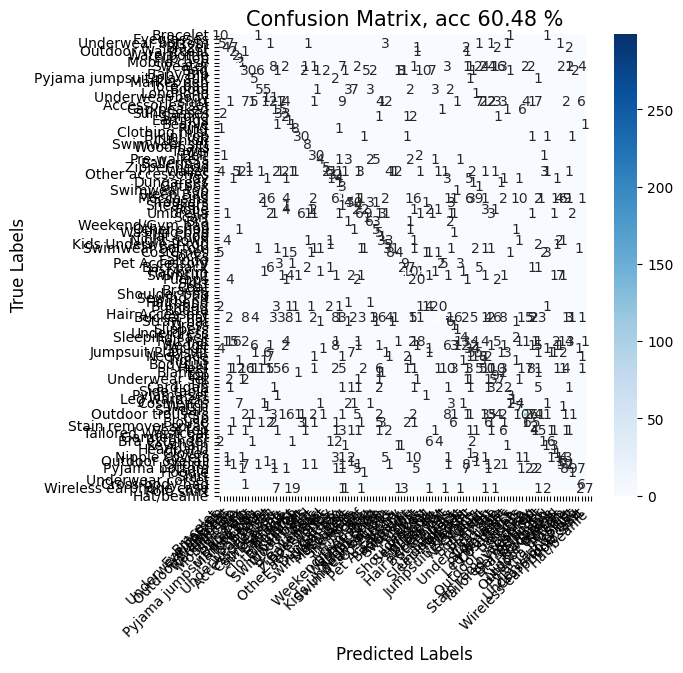

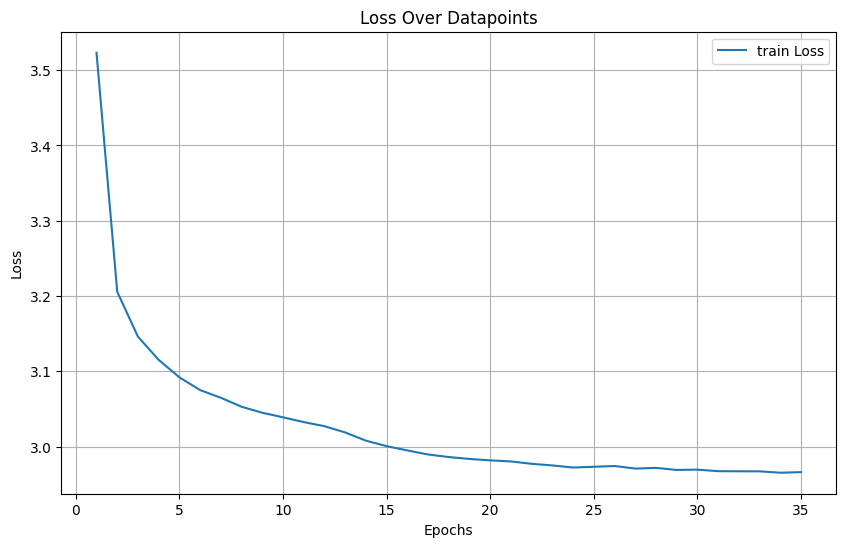

<Figure size 640x480 with 0 Axes>

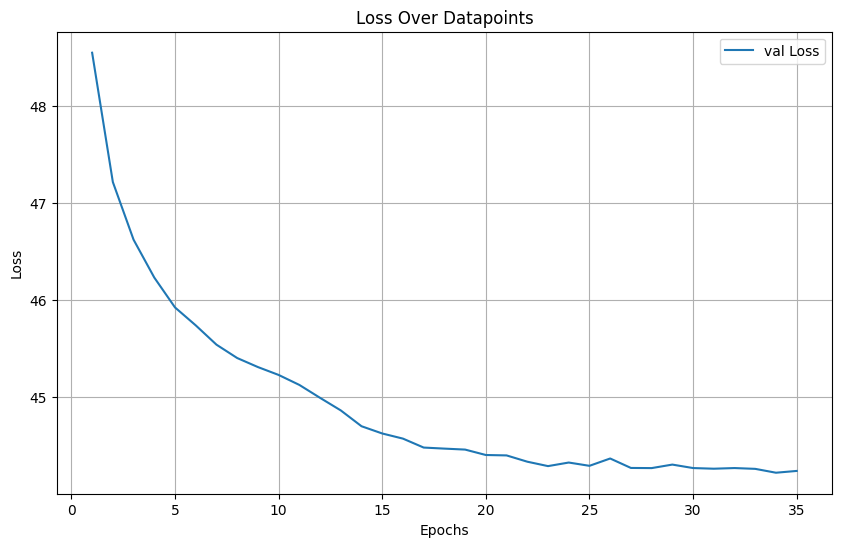

Training:  36%|███▌      | 36/100 [50:49<1:57:01, 109.71s/epoch, Patience=0 / 40]

Patience reset, New Min Loss = 662.8785283565521
Epoch 36: Optimizer - Learning Rate: 0.0001, Number of Parameters: 2097152
Epoch 36: Training on hard samples - Max allowed = 560, Current count = 560


In [ ]:

update()
ranks = [0, 0, 0, 0, 0, 0,0, 0,0, 0, 256, 256]  # Only apply LoRA with rank 64 to the last layer

#ranks = [256, 256, 256, 256, 256, 256, 256, 256,256, 256, 256, 256]  # Only apply LoRA with rank 64 to the last layer
lr = 1e-04
wd = 0.001
epochs_num = 100
lora_layers = []

clip = {'m': copy.deepcopy(model), 'p': processor} # do not load each time
lora_layers = model_functions.apply_lora_to_transformer(clip['m'].text_model.encoder.layers , lora_layers, ranks)
lora_params_attention = model_functions.get_lora_params(clip['m'], print_layer = True)


ft = training.FinetuneCLIP(dataloaders, clip, epochs = epochs_num )
ft.conf = {'epochs': epochs_num, 'balanced':BALANCED}
ft.model_prefix = "lora-cap-5000-3-200-start"

# Initialize LoRA training with current hyperparameters
ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc'] = 0, 1 ,0 # Enable LoRA
ft.initialize({'LoRA': lora_params_attention, 'lr': lr, 'weight_decay': wd, 'num_soft':0, 'add':''},
              load=False, file_name=file_name)
ft.hard_mining = True
ft.focal_loss_gamma = 1.5

ft.count_parameters()
#all_predictions, all_labels, acc = ft.eval(False)

# Train the model
ft.es['pat']=40
ft.train()

# Evaluate the model
all_predictions, all_labels, acc = ft.eval(False)
utils.confussion_matrix(all_labels, all_predictions, list(dataloaders['test'].dataset.class_to_id.keys()), F1=False)
ft.plot_loss_key('train', 'final')
ft.plot_loss_key('val', 'final')

print(f"Accuracy for rank configuration {ranks} with lr={lr}, wd={wd} is {acc:.2f} %")